In [28]:
from glob import glob
import os
import gzip
import shutil
import pandas as pd
import matplotlib.pyplot as plt

from data_processing import *

import pickle

In [19]:
def unpack(dir_path = '../data/'):
    list_of_files = glob(dir_path + '*.gz')
    for f in glob(dir_path + '*.gz'):
        with gzip.open(f, 'rb') as f_in:
            with open(f[:-3] + '.csv', 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
            
unpack()

In [20]:
def merge(dir_path = '../data/'):
    files = sorted([f for f in os.listdir(dir_path) if f[-6:] == '00.csv'])
    merged_df = pd.concat([pd.read_csv(dir_path + f) for f in files])

    merged_df['czas'] = pd.to_datetime(merged_df['czas'])
    assert merged_df['czas'].is_monotonic_increasing

    merged_df.to_csv(dir_path + 'merged.csv', index=False)
    
    return merged_df
df_og = merge()

In [21]:
k = 15 # number of minutes in cluster
df_og = aggregate(df_og, k)

/home/weronika/University/cuvalley/load_and_predict/data_processing.py:129: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  if not type(agg_df['czas']) is pd.datetime:


### Proste featury wybieram albo tworze agregując

In [22]:
df = pd.DataFrame(index=df_og.index)

# srednia po 'WODY POWROTNE KOLEKTORÓW [°C]'
TIR = df_og.columns[df_og.columns.str.contains('tir')].values
df['TIR'] = df_og[TIR].mean(axis='columns')

# srednia po 'TEMP POD 2 WARSTWĄ WYMURÓWKI [°C]'
TIX1 = df_og.columns[df_og.columns.str.contains('001tix')].values
df['TIX1'] = df_og[TIX1].mean(axis='columns')

# prob_s i prob_corg
PR = ['prob_s', 'prob_corg']
df[PR] = df_og[PR]

# reg nadawy koncentratu
FCX = df_og.columns[df_og.columns.str.contains('fcx')].values
df['FCX'] = df_og[FCX].mean(axis='columns')

# sumaryczna moc cieplna
NIR = df_og.columns[df_og.columns.str.contains('nir')].values
df['NIR'] = df_og[NIR]

# WENT ODCZ ZAD OBROTÓW
UXM = df_og.columns[df_og.columns.str.contains('uxm')].values
df['UXM'] = df_og[UXM].mean(axis='columns')

### Loading mean and scale from historical data to standarize features

In [23]:
mean = pickle.load(open('mean.sav', 'rb'))
scl = pickle.load(open('scale.sav', 'rb'))

### Standarizing data 

In [24]:
df = df.sub(mean).div(scl)

### Loading pre-trained model

In [25]:
filename = 'finalized_model.sav'
model = pickle.load(open(filename, 'rb'))

/home/weronika/anaconda3/envs/cuvalleyhack/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/weronika/anaconda3/envs/cuvalleyhack/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator Ridge from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/weronika/anaconda3/envs/cuvalleyhack/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator Pipeline from version 0.23.2 when using

### Predicting: 

In [26]:
y_pred = pd.DataFrame(model.predict(df))
y_pred.index = df.index
y_pred.columns = ['temp_zuz']
y_pred

/home/weronika/anaconda3/envs/cuvalleyhack/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


,temp_zuz
czas,
2022-01-27 00:00:00+01:00,1301.813721
2022-01-27 00:15:00+01:00,1301.862632
2022-01-27 00:30:00+01:00,1301.500538
2022-01-27 00:45:00+01:00,1301.577167
2022-01-27 01:00:00+01:00,1301.207197
...,...
2022-01-30 23:00:00+01:00,1298.491263
2022-01-30 23:15:00+01:00,1298.174553
2022-01-30 23:30:00+01:00,1298.066945


### Plot predicted values

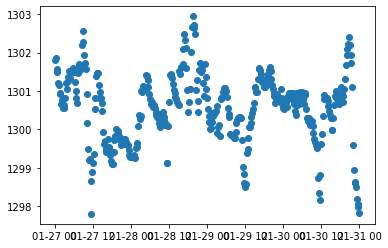

In [29]:
plt.scatter(y_pred.index, y_pred['temp_zuz'])
plt.show()

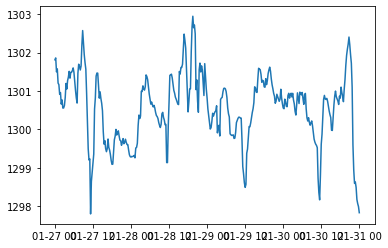

In [30]:
plt.plot(y_pred.index, y_pred['temp_zuz'])
plt.show()